# Order effects in sequential Counterfactual Reasoning

This notebook serves as an interactive tool for testing thr model predictions of the `static_twin` sequential counterfactual inference model.

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ...existing code...
import sys
import os

# Ensure we can see the CfModels package (since notebook is in a subdir)
sys.path.append(os.path.abspath('..'))

In [2]:
# Model imports
from CfModels.networks import create_diamond_bayesian_network

## Model representation

In [3]:
import networkx as nx

/var/folders/cg/49fv39xs0w7b42v0thstyfvw0000gq/T/ipykernel_86569/3617954195.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


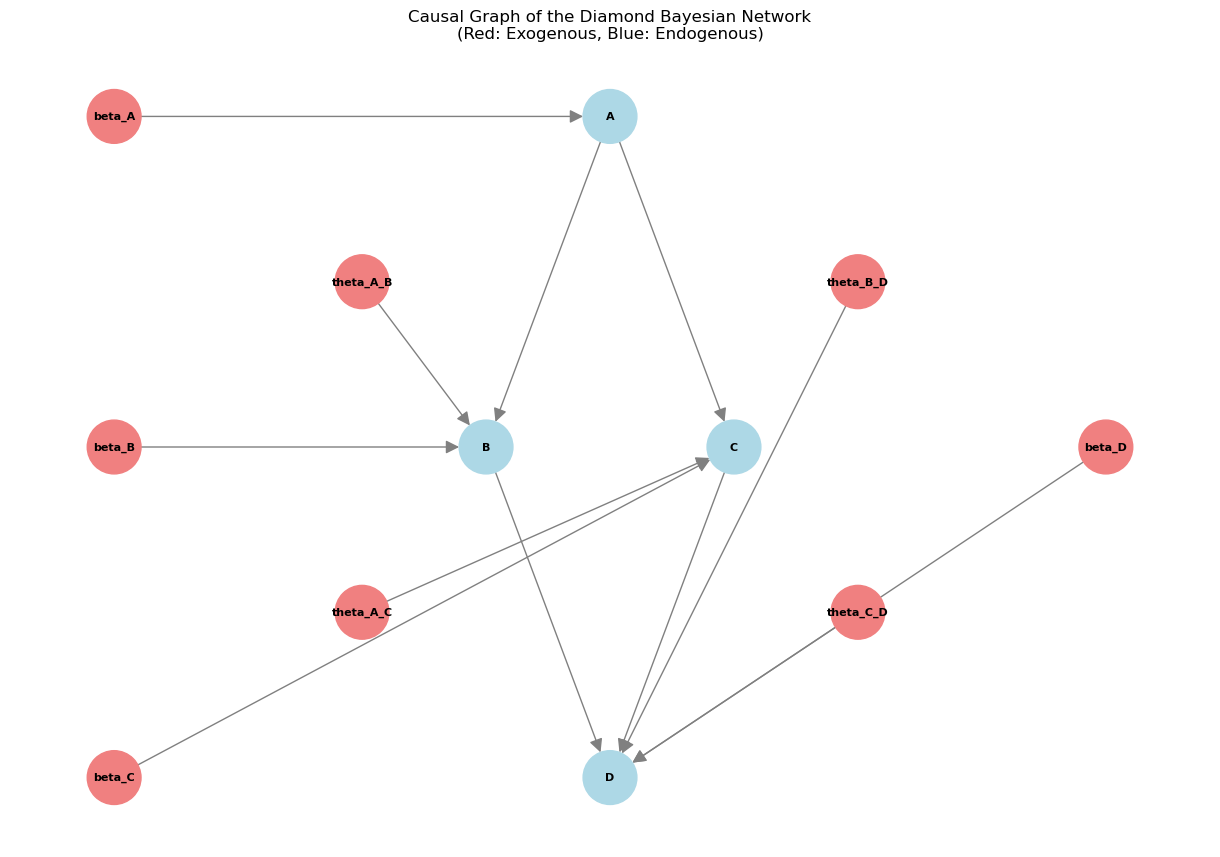

In [4]:
# Create the diamond Bayesian Network
diamond_bn = create_diamond_bayesian_network()

# Draw the causal graph of the diamond Bayesian Network
plt.figure(figsize=(12, 8))

# Get the networkx graph from the Bayesian Network
G = diamond_bn

# Define positions for better layout
pos = {
    # Exogenous variables for base rates
    'beta_A': (-2, 2),
    'beta_B': (-2, 0),
    'beta_C': (-2, -2),
    'beta_D': (2, 0),
    
    # Exogenous variables for causal powers
    'theta_A_B': (-1, 1),
    'theta_A_C': (-1, -1),
    'theta_B_D': (1, 1),
    'theta_C_D': (1, -1),
    
    # Endogenous variables (diamond structure)
    'A': (0, 2),
    'B': (-0.5, 0),
    'C': (0.5, 0),
    'D': (0, -2)
}

# Define node colors
node_colors = []
for node in G.nodes():
    if node.startswith('beta_') or node.startswith('theta_'):
        node_colors.append('lightcoral')  # Exogenous variables in red
    else:
        node_colors.append('lightblue')   # Endogenous variables in blue

# Draw the network
nx.draw(G, pos=pos, with_labels=True, node_size=1500, 
        node_color=node_colors, font_size=8, font_weight='bold', 
        arrows=True, arrowsize=20, edge_color='gray')

plt.title("Causal Graph of the Diamond Bayesian Network\n(Red: Exogenous, Blue: Endogenous)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Interactive Predictions

## Display definition

In [5]:
import ipywidgets as widgets
from IPython.display import display

from CfModels.plotting import analyze_ordering_effects
from CfModels.order_methods import static_twin

def create_interactive_ordering_analysis():
    """
    Create an interactive widget to explore ordering effects in counterfactual reasoning.
    """
    
    # Create parameter sliders
    beta_A_slider = widgets.FloatSlider(
        value=0.95, min=0.01, max=0.99, step=0.01,
        description='beta_A:', style={'description_width': 'initial'}
    )
    beta_B_slider = widgets.FloatSlider(
        value=0.01, min=0, max=1, step=0.01,
        description='beta_B:', style={'description_width': 'initial'}
    )
    beta_C_slider = widgets.FloatSlider(
        value=0.01, min=0, max=1, step=0.01,
        description='beta_C:', style={'description_width': 'initial'}
    )
    beta_D_slider = widgets.FloatSlider(
        value=0.1, min=0, max=1, step=0.01,
        description='beta_D:', style={'description_width': 'initial'}
    )
    power_B_slider = widgets.FloatSlider(
        value=0.9, min=0, max=1, step=0.01,
        description='power_B:', style={'description_width': 'initial'}
    )
    power_C_slider = widgets.FloatSlider(
        value=0.9, min=0, max=1, step=0.01,
        description='power_C:', style={'description_width': 'initial'}
    )
    power_D_from_B_slider = widgets.FloatSlider(
        value=0.9, min=0, max=1, step=0.01,
        description='power_D_from_B:', style={'description_width': 'initial'}
    )
    power_D_from_C_slider = widgets.FloatSlider(
        value=0.9, min=0, max=1, step=0.01,
        description='power_D_from_C:', style={'description_width': 'initial'}
    )
    s_slider = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01,
        description='Stability (s):', style={'description_width': 'initial'}
    )

    p_slider = widgets.FloatSlider(
        value=1.0, min=0.0, max=1.0, step=0.01,
        description='p_keep:', style={'description_width': 'initial'}
    )

    disjunction_checkbox = widgets.Checkbox(
        value=True, description='Disjunction (vs Conjunction)'
    )
    
    # Observation buttons
    obs_A_button = widgets.ToggleButtons(
        options=[0, 1], value=1, description='Observed A:',
        style={'description_width': 'initial'},
        button_style=''
    )
    obs_B_button = widgets.ToggleButtons(
        options=[0, 1], value=1, description='Observed B:',
        style={'description_width': 'initial'},
        button_style=''
    )
    obs_C_button = widgets.ToggleButtons(
        options=[0, 1], value=1, description='Observed C:',
        style={'description_width': 'initial'},
        button_style=''
    )
    obs_D_button = widgets.ToggleButtons(
        options=[0, 1], value=1, description='Observed D:',
        style={'description_width': 'initial'},
        button_style=''
    )
    
    # Counterfactual constraint slider
    cf_B_button = widgets.ToggleButtons(
        options=[0, 1], value=0, description='CF B:',
        style={'description_width': 'initial'},
        button_style=''
    )

    # temperature slider
    temperature_slider = widgets.FloatSlider(
        value=1, min=0.01, max=3, step=0.01,
        description='Temperature:',
        style={'description_width': 'initial'}
    )

    def update_plot(beta_A, beta_B, beta_C, beta_D, power_B, power_C, 
                    power_D_from_B, power_D_from_C, 
                    s, p_keep, temperature, disjunction,
                    obs_A, obs_B, obs_C, obs_D, cf_B,):
        
        # Set up observations and counterfactual constraints
        obs = {'A': obs_A, 'B': obs_B, 'C': obs_C, 'D': obs_D}
        cf_constraint = {'B': cf_B}
        
        # Run the analysis
        try:
            order_effects = analyze_ordering_effects(
                inference_method=static_twin,
                beta_A=beta_A, beta_B=beta_B, beta_C=beta_C, beta_D=beta_D,
                power_B=power_B, power_C=power_C, 
                power_D_from_B=power_D_from_B, power_D_from_C=power_D_from_C,
                disjunction=disjunction, s=s, p_keep=p_keep, obs=obs, cf_constraint=cf_constraint,
                temperature=temperature if temperature != 0 else None,
            )
            
            
            # Create the plots
            fig, ax1 = plt.subplots(figsize=(15, 6))

            # Plot 1: Probabilities by ordering
            variables = ['A', 'C', 'D']
            ACD_probs = [order_effects['A_ACD'], order_effects['C_ACD'], order_effects['D_ACD']]
            DCA_probs = [order_effects['A_DCA'], order_effects['C_DCA'], order_effects['D_DCA']]

            ax1.plot(variables, ACD_probs, 'o-', label='ACD ordering', linewidth=3, markersize=10, color='blue')
            ax1.plot(variables, DCA_probs, 's-', label='DCA ordering', linewidth=3, markersize=10, color='red')
            ax1.set_title('Counterfactual Probabilities by Variable Ordering', fontsize=14)
            ax1.set_ylabel('P(Variable=1|evidence, cf_constraint)', fontsize=12)
            ax1.set_xlabel('Variables', fontsize=12)
            ax1.legend(fontsize=12)
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 1)

            # Add value labels on points
            for i, (var, acd_prob, dca_prob) in enumerate(zip(variables, ACD_probs, DCA_probs)):
                ax1.annotate(f'{acd_prob:.3f}', (i, acd_prob), textcoords="offset points", 
                            xytext=(0,10), ha='center', fontsize=10, color='blue')
                ax1.annotate(f'{dca_prob:.3f}', (i, dca_prob), textcoords="offset points", 
                            xytext=(0,-15), ha='center', fontsize=10, color='red')



            plt.tight_layout()
            plt.show()
            
            # Print numerical results
            print("="*60)
            print("NUMERICAL RESULTS")
            print("="*60)
            print(f"ACD Ordering: A={order_effects['A_ACD']:.4f}, C={order_effects['C_ACD']:.4f}, D={order_effects['D_ACD']:.4f}")
            print(f"DCA Ordering: A={order_effects['A_DCA']:.4f}, C={order_effects['C_DCA']:.4f}, D={order_effects['D_DCA']:.4f}")
            
        except Exception as e:
            print(f"Error in computation: {e}")
            plt.figure(figsize=(8, 4))
            plt.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', fontsize=12)
            plt.axis('off')
            plt.show()
    
    # Create the interactive widget
    interactive_widget = widgets.interact(
        update_plot,
        beta_A=beta_A_slider,
        beta_B=beta_B_slider,
        beta_C=beta_C_slider,
        beta_D=beta_D_slider,
        power_B=power_B_slider,
        power_C=power_C_slider,
        power_D_from_B=power_D_from_B_slider,
        power_D_from_C=power_D_from_C_slider,
        s=s_slider,
        p_keep=p_slider,
        disjunction=disjunction_checkbox,
        obs_A=obs_A_button,
        obs_B=obs_B_button,
        obs_C=obs_C_button,
        obs_D=obs_D_button,
        cf_B=cf_B_button,
        temperature=temperature_slider
    )
    
    return interactive_widget

## Order Effects Playground

### Mean Judgement predictions

In [6]:
# Create and display the interactive widget
interactive_analysis = create_interactive_ordering_analysis()

interactive(children=(FloatSlider(value=0.95, description='beta_A:', max=0.99, min=0.01, step=0.01, style=Slid…

### Marginal Exogenous Probabilities prior to each counterfactual query

In [7]:
from CfModels.order_methods import static_twin
from CfModels.plotting import plot_exogenous_evolution, order_effects
from CfModels.inference import CounterfactualInferenceBN

In [8]:
def static_twin_exog(**params):
    return static_twin(**params,compute_exogenous=True)

In [13]:
order_effects_result = order_effects(
    inference_method=static_twin_exog,
    order = 'CDA'
)
order_effects_result

{'order': 'CDA',
 'params': {'beta_A': 0.5,
  'beta_B': 0.5,
  'beta_C': 0.5,
  'beta_D': 0.5,
  'power_B': 0.5,
  'power_C': 0.5,
  'power_D_from_B': 0.5,
  'power_D_from_C': 0.5,
  'disjunction': True,
  's': 0.5,
  'temperature': None,
  'p_keep': 1},
 'results': [{'path': [0, 0, 0],
   'probability': np.float64(0.1534090909090909),
   'P1': np.float64(0.5795454545454546),
   'P2': np.float64(0.375),
   'P3': np.float64(0.7058823529411764),
   'exogenous_marginals': {'prior': {'beta_C': np.float64(0.5),
     'theta_B_D': np.float64(0.5),
     'beta_D': np.float64(0.5),
     'beta_B': np.float64(0.5),
     'theta_C_D': np.float64(0.5),
     'theta_A_B': np.float64(0.5),
     'theta_A_C': np.float64(0.5),
     'beta_A': np.float64(0.5)},
    'marginals_q1': {'beta_C': np.float64(0.0),
     'theta_B_D': np.float64(0.5),
     'beta_D': np.float64(0.25),
     'beta_B': np.float64(0.8235294117647058),
     'theta_C_D': np.float64(0.5),
     'theta_A_B': np.float64(0.5882352941176471),
   

In [14]:
base_inf = CounterfactualInferenceBN(diamond_bn)

/Users/s2518809/Documents/Research/NLP_CDT/Neil-Dan/Agency/minimal_models/backtracking_counterfactuals/code/python/CfModels/plotting.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


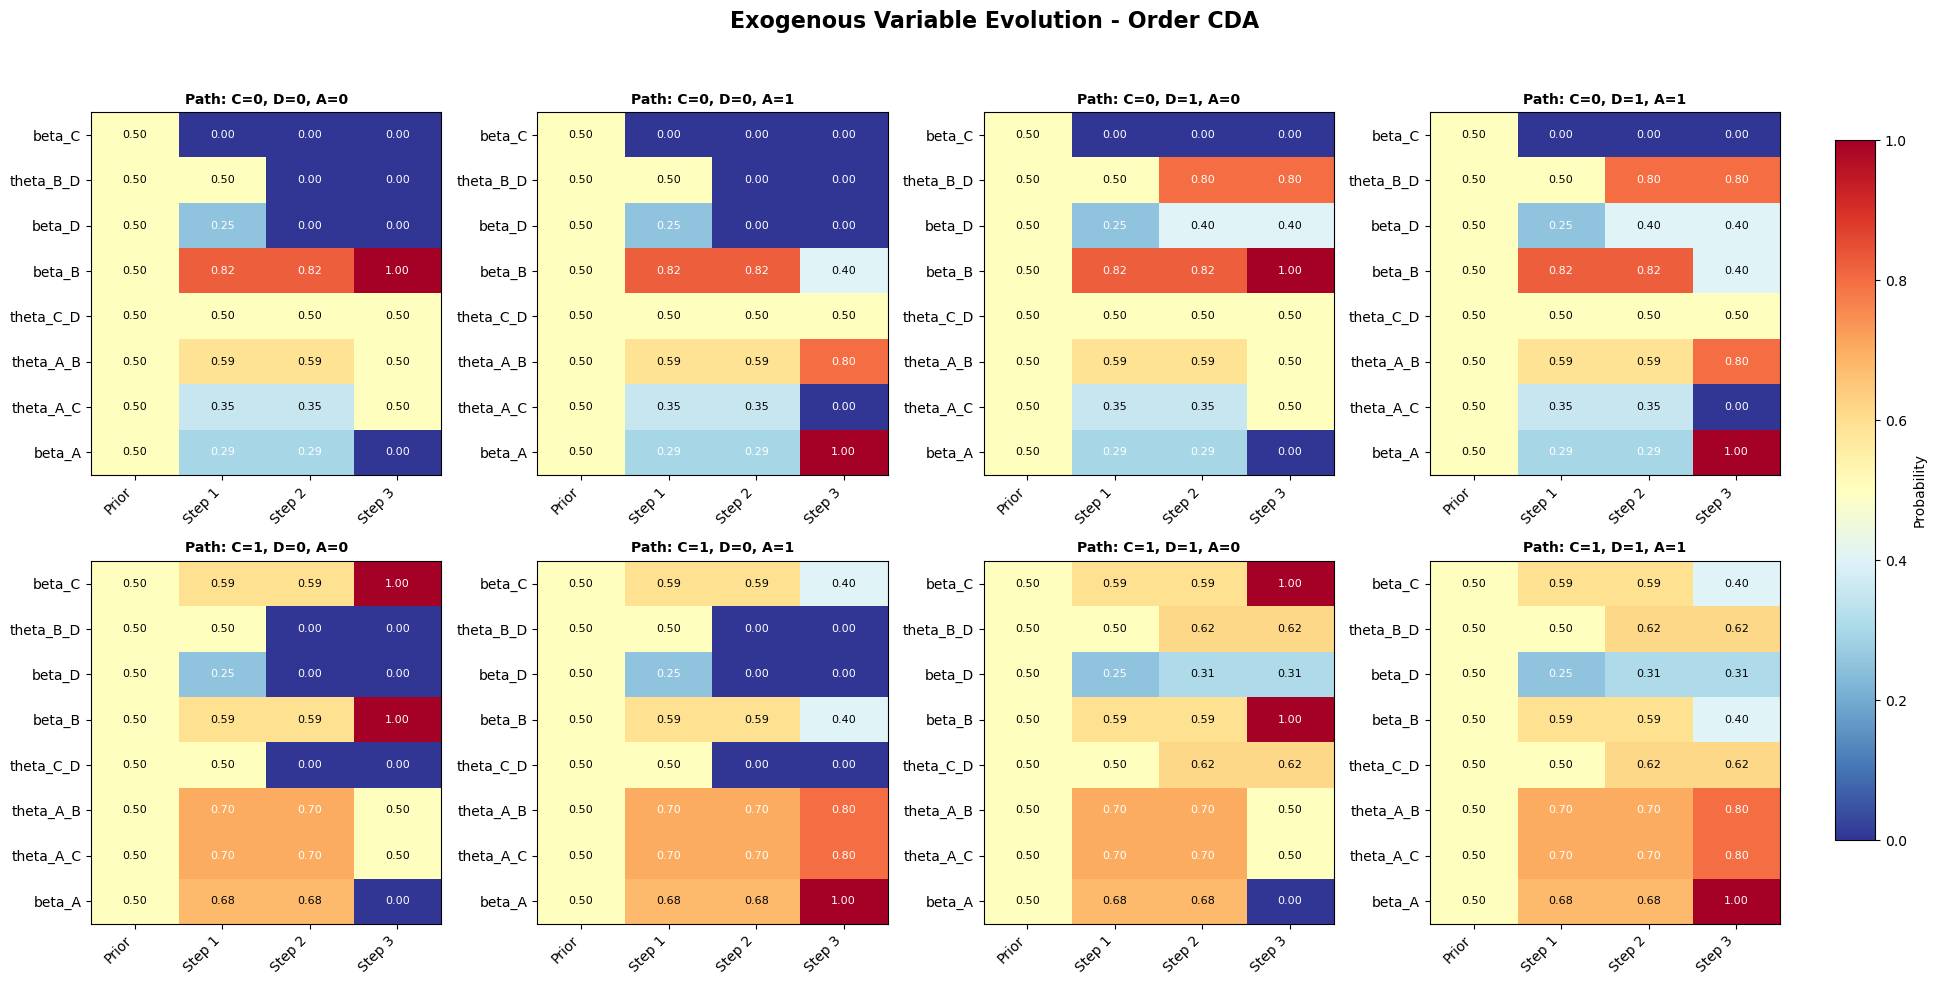

In [15]:
plot_exogenous_evolution(order_effects_result, exog_vars = list(base_inf.exogenous_vars))